# Working with Pandas and XArray

This notebook demonstrates how Pandas and XArray can be used to work with the [QCoDeS DataSet](DataSet-class-walkthrough.ipynb). It is not meant as a general introduction to Pandas and XArray. We refer to the official documentation for [Pandas](https://pandas.pydata.org/) and [XArray](http://xarray.pydata.org/en/stable/) for this. This notebook requires that both Pandas and XArray are installed.

## Setup

First we borrow an example from the measurement notebook to have some data to work with. We split the measurement in two so we can try merging it with Pandas.

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import qcodes as qc
from qcodes import load_or_create_experiment, initialise_database, Measurement
from qcodes.tests.instrument_mocks import DummyInstrument, DummyInstrumentWithMeasurement

qc.logger.start_all_logging()

Logging hadn't been started.
Activating auto-logging. Current session state plus future input saved.
Filename       : /home/vsts/.qcodes/logs/command_history.log
Mode           : append
Output logging : True
Raw input log  : False
Timestamping   : True
State          : active


Qcodes Logfile : /home/vsts/.qcodes/logs/201201-16957-qcodes.log
Activating auto-logging. Current session state plus future input saved.
Filename       : /home/vsts/.qcodes/logs/command_history.log
Mode           : append
Output logging : True
Raw input log  : False
Timestamping   : True
State          : active


Qcodes Logfile : /home/vsts/.qcodes/logs/201201-16957-qcodes.log


In [2]:
# preparatory mocking of physical setup
dac = DummyInstrument('dac', gates=['ch1', 'ch2'])
dmm = DummyInstrumentWithMeasurement('dmm', setter_instr=dac)
station = qc.Station(dmm, dac)

In [3]:
initialise_database()
exp = load_or_create_experiment(experiment_name='working_with_pandas',
                          sample_name="no sample")

In [4]:
meas = Measurement(exp)
meas.register_parameter(dac.ch1)  # register the first independent parameter
meas.register_parameter(dac.ch2)  # register the second independent parameter
meas.register_parameter(dmm.v2, setpoints=(dac.ch1, dac.ch2))  # register the dependent one

We then perform a very basic experiment. To be able to demonstrate merging of datasets in Pandas we will perform the measurement in two parts.

In [5]:
# run a 2D sweep

with meas.run() as datasaver:

    for v1 in np.linspace(-1, 0, 200, endpoint=False):
        for v2 in np.linspace(-1, 1, 201):
            dac.ch1(v1)
            dac.ch2(v2)
            val = dmm.v2.get()
            datasaver.add_result((dac.ch1, v1),
                                 (dac.ch2, v2),
                                 (dmm.v2, val))
            
df1 = datasaver.dataset.get_data_as_pandas_dataframe()['dmm_v2']

Starting experimental run with id: 49. 


In [6]:
# run a 2D sweep

with meas.run() as datasaver:

    for v1 in np.linspace(0, 1, 201):
        for v2 in np.linspace(-1, 1, 201):
            dac.ch1(v1)
            dac.ch2(v2)
            val = dmm.v2.get()
            datasaver.add_result((dac.ch1, v1),
                                 (dac.ch2, v2),
                                 (dmm.v2, val))
            
df2 = datasaver.dataset.get_data_as_pandas_dataframe()['dmm_v2']

Starting experimental run with id: 50. 


`get_data_as_pandas_dataframe` returns the data as a dict from measured (dependent) parameters to DataFrames. Here we are only interested in the dataframe of a single parameter, so we select that from the dict.

## Working with Pandas

Lets first inspect the Pandas DataFrame. Note how both dependent variables are used for the index. Pandas refers to this as a [MultiIndex](https://pandas.pydata.org/pandas-docs/stable/user_guide/advanced.html). For visual clarity, we just look at the first N points of the dataset.

In [7]:
N = 10

In [8]:
df1[:N]

dmm_v2
dac_ch1 dac_ch2          
-1.0    -1.00    0.000906
        -0.99    0.000851
        -0.98   -0.000730
        -0.97   -0.000818
        -0.96    0.000247
        -0.95    0.000755
        -0.94    0.000551
        -0.93   -0.000227
        -0.92    0.000467
        -0.91    0.000210

We can also reset the index to return a simpler view where all data points are simply indexed by a running counter. As we shall see below this can be needed in some situations. Note that calling `reset_index` leaves the original dataframe untouched.

In [9]:
df1.reset_index()[0:N]

,dac_ch1,dac_ch2,dmm_v2
0,-1.0,-1.00,0.000906
1,-1.0,-0.99,0.000851
2,-1.0,-0.98,-0.000730
3,-1.0,-0.97,-0.000818
4,-1.0,-0.96,0.000247
5,-1.0,-0.95,0.000755
6,-1.0,-0.94,0.000551
7,-1.0,-0.93,-0.000227
8,-1.0,-0.92,0.000467
9,-1.0,-0.91,0.000210


Pandas has built-in support for various forms of plotting. This does not, however, support MultiIndex at the moment so we use `reset_index` to make the data available for plotting.

<AxesSubplot:xlabel='dac_ch1', ylabel='dac_ch2'>

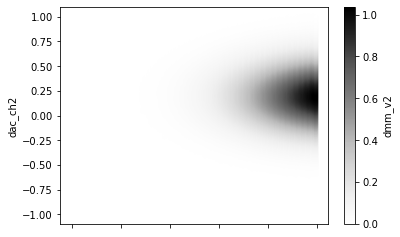

In [10]:
df1.reset_index().plot.scatter('dac_ch1', 'dac_ch2', c='dmm_v2')

Similarly, for the other dataframe:

<AxesSubplot:xlabel='dac_ch1', ylabel='dac_ch2'>

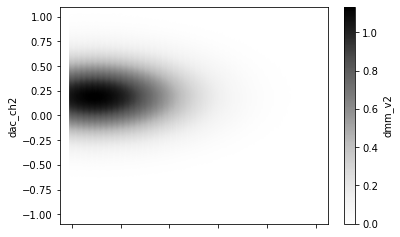

In [11]:
df2.reset_index().plot.scatter('dac_ch1', 'dac_ch2', c='dmm_v2')

Merging two dataframes with the same labels is fairly simple.

In [12]:
df = pd.concat([df1, df2], sort=True)

<AxesSubplot:xlabel='dac_ch1', ylabel='dac_ch2'>

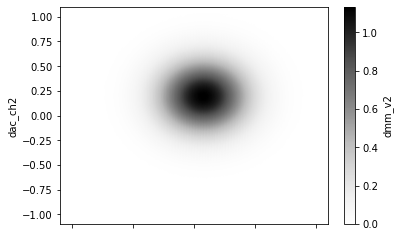

In [13]:
df.reset_index().plot.scatter('dac_ch1', 'dac_ch2', c='dmm_v2')

It is also possible to select a subset of data from the datframe based on the x and y values.

In [14]:
df.loc[(slice(-1, -0.95), slice(-1, -0.97)), :]

dmm_v2
dac_ch1 dac_ch2              
-1.000  -1.00    9.057054e-04
        -0.99    8.510135e-04
        -0.98   -7.304719e-04
        -0.97   -8.178527e-04
-0.995  -1.00    2.701095e-04
        -0.99    1.000473e-03
        -0.98   -4.774215e-04
        -0.97    3.623094e-04
-0.990  -1.00    2.749155e-04
        -0.99    3.749324e-04
        -0.98   -4.626356e-06
        -0.97   -3.677704e-04
-0.985  -1.00    2.978652e-04
        -0.99    4.029684e-04
        -0.98    7.945973e-04
        -0.97    4.785151e-07
-0.980  -1.00   -3.682325e-04
        -0.99   -3.850197e-04
        -0.98   -1.035769e-04
        -0.97   -8.160121e-04
-0.975  -1.00   -3.132652e-04
        -0.99   -1.965899e-04
        -0.98    9.093193e-04
        -0.97   -7.192144e-05
-0.970  -1.00   -1.108089e-03
        -0.99    7.831398e-05
        -0.98   -8.001180e-04
        -0.97    3.487501e-05
-0.965  -1.00   -4.747304e-04
        -0.99   -3.138370e-04
        -0.98   -1.927063e-04
        -0.97   -7.409961e-04
-0.960  -1.00    4.096100e-04
        -0.99   -1.775002e-04
        -0.98   -1.005409e-04
        -0.97   -1.372688e-04
-0.955  -1.00    3.900713e-04
        -0.99   -4.253846e-04
        -0.98    2.152458e-04
        -0.97   -5.607420e-04
-0.950  -1.00   -9.631499e-04
        -0.99   -9.264498e-05
        -0.98    2.423212e-04
        -0.97   -3.551157e-05

## Working with XArray

In many cases when working with data on a rectangular grids it may be more convenient to export the data to a [XArray](http://xarray.pydata.org) Dataset or DataArray

The Pandas DataSet can be directly converted to a XArray [Dataset](http://xarray.pydata.org/en/stable/data-structures.html?#dataset):

In [15]:
xaDataSet = df.to_xarray()

In [16]:
xaDataSet

<xarray.Dataset>
Dimensions:  (dac_ch1: 401, dac_ch2: 201)
Coordinates:
  * dac_ch1  (dac_ch1) float64 -1.0 -0.995 -0.99 -0.985 ... 0.985 0.99 0.995 1.0
  * dac_ch2  (dac_ch2) float64 -1.0 -0.99 -0.98 -0.97 ... 0.97 0.98 0.99 1.0
Data variables:
    dmm_v2   (dac_ch1, dac_ch2) float64 0.0009057 0.000851 ... 0.0001721

However, in many cases it is more convenient to work with a XArray [DataArray](http://xarray.pydata.org/en/stable/data-structures.html?#dataarray). The DataArray can only contain a single dependent variable and can be obtained from the Dataset by indexing using the parameter name.

In [17]:
xaDataArray = xaDataSet['dmm_v2']

In [18]:
xaDataArray

<xarray.DataArray 'dmm_v2' (dac_ch1: 401, dac_ch2: 201)>
array([[ 9.05705376e-04,  8.51013463e-04, -7.30471943e-04, ...,
         9.51663623e-04, -4.96340165e-04, -3.65078418e-04],
       [ 2.70109536e-04,  1.00047283e-03, -4.77421469e-04, ...,
        -1.22024263e-04, -2.00701070e-05,  6.06643222e-05],
       [ 2.74915534e-04,  3.74932389e-04, -4.62635573e-06, ...,
         8.61904190e-04,  1.72245475e-04,  5.75848660e-04],
       ...,
       [-7.28165546e-04, -4.44628216e-04, -1.96103478e-04, ...,
         1.87669116e-04, -8.95469767e-06,  2.00296435e-04],
       [ 9.95227094e-04, -3.02308485e-04, -7.99793599e-04, ...,
        -3.37133094e-04,  2.41316028e-04, -1.57584832e-04],
       [ 1.05459981e-03,  8.11667362e-04,  6.05744574e-04, ...,
        -1.68309313e-04,  4.40862526e-04,  1.72131802e-04]])
Coordinates:
  * dac_ch1  (dac_ch1) float64 -1.0 -0.995 -0.99 -0.985 ... 0.985 0.99 0.995 1.0
  * dac_ch2  (dac_ch2) float64 -1.0 -0.99 -0.98 -0.97 ... 0.97 0.98 0.99 1.0

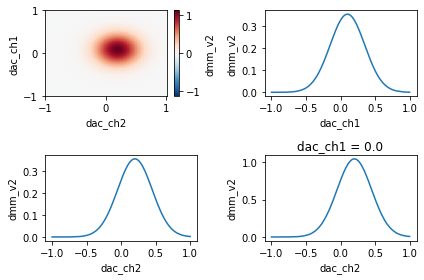

In [19]:
fig, ax = plt.subplots(2,2)
xaDataArray.plot(ax=ax[0,0])
xaDataArray.mean(dim='dac_ch1').plot(ax=ax[1,0])
xaDataArray.mean(dim='dac_ch2').plot(ax=ax[0,1])
xaDataArray[200,:].plot(ax=ax[1,1])
fig.tight_layout()

Above we demonstrated a few ways to index the data from a DataArray. For instance the DataArray can be directly plotted, the extracted mean or a specific row/column can also be plotted.